## Author: Jakub Bartkowiak
### Colaborator: Deja Batiste 
#### Webscrape of https://en.wikipedia.org/wiki/Transistor_count

In [1]:
import requests
from bs4 import BeautifulSoup
import csv
import os
import re
import unicodedata

In [2]:
def fetch_html(url):
    """Fetch HTML content of the URL and handle HTTP errors."""
    response = requests.get(url)
    try:
        response.raise_for_status()
        #print("HTTP req successful")
    except requests.exceptions.HTTPError as e:
        print(f"HTTP request failure. Statuss code: {response.status_code}. Error: {e}")
    return response.text

# Configuration parameters
site_url_stem = "https://en.wikipedia.org/wiki/"
query = "transistor count"
formatted_query = query.replace(" ", "_")
url = site_url_stem + formatted_query

# Fetch HTML
html = fetch_html(url)
#print(f"URL = {url}")
#print("HTML fetched successfully:", html[:100])  # print a few characters to ensure output is as expected


In [3]:
def parse_table(html):
    """Parse HTML to find the table(s)."""
    soup = BeautifulSoup(html, 'html.parser')
    table = soup.find('table', {'class': 'wikitable sortable'})
    if table:
        print("Table found in the HTML")
    else:
        print("No table found with that class, check the HTML")
    return table

# Parse the HTML to find the table
table = parse_table(html)
print("Table parsed successfully:", str(table)[:100])

Table found in the HTML
Table parsed successfully: <table class="wikitable sortable" style="text-align:left;">
<tbody><tr>
<th width="300px"><a href="/


In [4]:
def clean_text(text):
    """Clean text extracted from HTML to remove references and make sure encoding is correct to prevent odd characters"""

    #print(f"text prior to numeric cleaning: {text}")
    text = unicodedata.normalize('NFKD', text)# normalize Unicode characters

    text = re.sub(r'\[.*?\]', '', text) #remove anything in brackets, aka references
    text = re.sub(r'\xa0', ' ', text)
    text = re.sub(r'[^\x00-\x7F]+', ' ', text) # Remove non-ASCII characters

    text = text.strip()#strip to remove leading/trailing whitespac
    text = text.encode('utf-8', 'ignore').decode('utf-8')# encode and decode to remove non-UTF8 characters
    text = text.strip()

    # Remove text within parentheses and commas, pluses before checking for numeric patterns
    text = re.sub(r'\(.*?\)', '', text)
    text = re.sub(r',|\+', '', text)

    if len(text) >= 3 and (text[0].isdigit() or text[0] == '.'): # Check if the first three characters are numeric or a period
        match = re.search(r'^[\d.]+', text)
        if match:
            text = match.group(0) # Get the complete numeric match
        #print(f"text after numeric cleaning: {text}")
    return text


def process_table(table):
    """Process table HTML to extract headers and rows"""
    headers = [clean_text(th.get_text(strip=True)) for th in table.find_all('th')]
    rows = []
    for tr in table.find_all('tr'):
        cols = [clean_text(td.get_text(strip=True)) for td in tr.find_all('td')]
        if cols:
            rows.append(cols)
    #print("Table processing complete.")
    return [headers] + rows

if table is not None:
    table_data = process_table(table)
    print("Processed table data:", table_data[0])  # Print only the headers/possibly some data
else:
    print("No data to process.")


Processed table data: ['Processor', 'Transistor count', 'Year', 'Designer', 'Process', 'Area ', 'Transistordensity', 'Processor', 'Transistor count', 'Year', 'Designer', 'Process', 'Area ', 'Transistordensity']


In [5]:
def save_to_csv(data, file_path):
    #print(f"File path: {file_path}")
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)
    print(f"data save to CSV at {file_path}")

# Save the table data to CSV
if table_data:
    #output_path = os.path.join(os.getcwd(), f"{formatted_query}.csv")
    output_path = os.path.join(os.getcwd(), f"CSC221-webscrape-data.csv")
    save_to_csv(table_data, output_path)


data save to CSV at C:\Users\School\Documents\CSC 221\GroupProject\CSC221-webscrape-data.csv


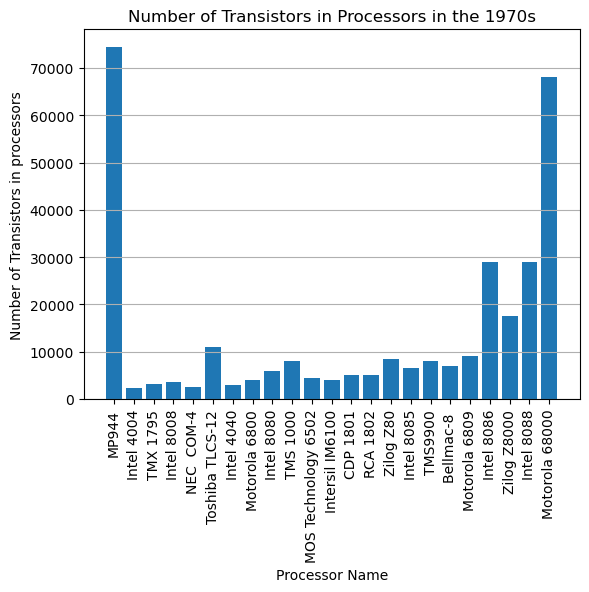

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
# Create dataframe from csv 
# only using first 3 columns
dataFrame = pd.read_csv("CSC221-webscrape-data.csv", nrows=23, usecols=[0,1,2])


# create and plot first graph based on entire dataFrame 
plt.title("Number of Transistors in Processors in the 1970s")
plt.bar(dataFrame["Processor"], dataFrame["Transistor count"])
plt.xticks([x for x in range(len(dataFrame["Processor"]))], dataFrame["Processor"], fontsize=10, rotation=90)

plt.xlabel("Processor Name")
plt.ylabel("Number of Transistors in processors")
plt.grid(axis='y')
plt.show()





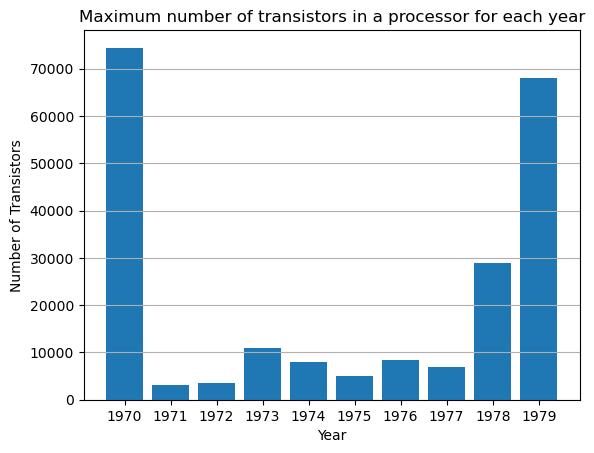

In [6]:
# get max transistor count for each year 
max_vals = [dataFrame.query(f"Year == {yr}").max() for yr in range(1970,1980)]
maxDataFrame = pd.DataFrame(max_vals)

# create and plot 2nd graph based on max transistors by year
plt.title("Maximum number of transistors in a processor for each year")
plt.bar(maxDataFrame["Processor"], maxDataFrame["Transistor count"])
plt.xticks([x for x in range(len(maxDataFrame["Year"]))], maxDataFrame["Year"])

plt.xlabel("Year")
plt.ylabel("Number of Transistors")
plt.grid(axis='y')
plt.show()

